In [1]:
from tools.Nth_Order_ECM import Nth_Order_ECM
from tools.tools import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from pathlib import Path
import torch
import time
torch.manual_seed(1)

In [2]:
# Load the FUDS csv file
fuds = pd.read_csv("data/LGHE4_data/HE4C25B01_MultiFUDS_25dg_fan_startS5_NormTab.csv")

# Load the ECM parameter
_,_,ecm_param_mean = load_data_LGHE4C25B01_Parameter()

# Extract the relevant data for the ECM and the NNs:
# Extract time step dt (here the average time step)
dt = np.mean(np.diff(fuds["Test_Time"].values.astype(np.float32)))

# Extract the Current array
I = fuds["Current"].values.astype(np.float32)

# Extract maximum capacity of the battery
C_ref = 2.5# np.max(fuds["Charge_Capacity"].values.astype(np.float32))

# Extract the SOC array: (charge capacity array)/max charge capacity
soc = fuds["Charge_Capacity"].values.astype(np.float32)/C_ref

# Create temperature array (the name of the csv file has 25dg in it. So I suppose T= 25°C)
T = np.ones(np.shape(I))*25.0

# Extract the terminal voltage array
U = fuds["Voltage"].values.astype(np.float32)

C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_29472\1913018336.py:2: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_29472\1913018336.py:2: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_29472\1913018336.py:2: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_29472\1913018336.py:2: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_29472\1913018336.py:2: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Tem

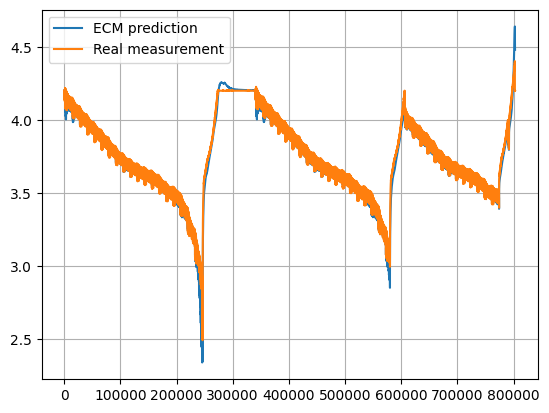

In [3]:
# Simulate ECM with FUDS data
f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
bm = Nth_Order_ECM(R0=f["R0"], 
                       Rs=[f["R1"],f["R2"]],
                       Taus=[f["Tau1"],f["Tau2"]],
                       ocv_grid=f["ocv_grid"],
                       C_ref=C_ref*3600,
                       soc_init=1, 
                       ts=dt)
fuds_log = simulate_ecm(ecm=bm, current=I)
plt.plot(fuds_log["V"], label="ECM prediction")
plt.plot(U, label="Real measurement")
plt.legend()
plt.grid()
plt.show()

In [4]:
# Load the previous trained CNN 
# Model parameters, same from optuna with the schedules dataset with some changes

input_keys = ["soc","I","T"]
output_keys = ["V"]
cnn_batch_size = 128
cnn_sequence_length = 2
cnn_num_layers = 4
cnn_num_neurons = 164
# cnn_learning_rate = 0.0006035398219949883
cnn_learning_rate = 0.00026406348065722505 # learning rate has been adjusted for the bmw i3 dataset to get a better performance
# cnn_num_epochs = 30
cnn_num_epochs = 3 # number of epochs have been adjusted for the bmw i3 dataset to get a better performance

# Set device 
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Instantiate CNN model with the same parameters as the one trained
cnn_model = CNN_model(num_layers=cnn_num_layers, 
                      num_neurons=cnn_num_neurons, 
                      sequence_length=cnn_sequence_length, 
                      input_keys=input_keys, 
                      output_keys=output_keys)

# Load the CNN state dictionary
cnn_model.load_state_dict(torch.load("data/best_cnn_ecm_trained.pth"))

cnn_model.to(device=device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate)  # Adam optimizer


# Load the min_max_dict used to scale the training data
with open(Path("data/data.bin"), "rb") as f:
    # Load the pickled data
    _ = pickle.load(f)
_ = flatten_dict(_)
_, min_max_dict = scale_dict(_)
# Use the min_max_data to scale the measurements of the matlab file
data_lad, data_ela = format_LGHE4C25B01(min_max_dict,constant_temperature=True)
datasets = {"lad": data_lad, "ela": data_ela}

min_voltage = min_max_dict["V"][0]
max_voltage = min_max_dict["V"][1]
min_temperature = min_max_dict["T"][0]
max_temperature = min_max_dict["T"][1]

c:\Users\Bouraoui\Documents\Job\ecm_lstm_cnn\tools\tools.py:892: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(input, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)


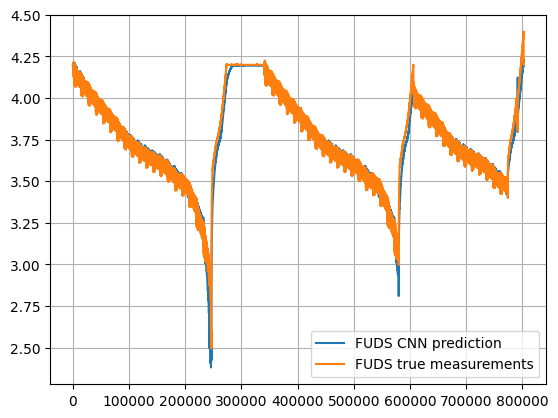

In [5]:
# Test CNN on the FUDS data (again)
min_temperature = min_max_dict["T"][0]
max_temperature = min_max_dict["T"][1]
fuds_scaled_voltage = (U-min_voltage)/(max_voltage-min_voltage)
fuds_scaled_temperature = (T-min_temperature)/(max_temperature-min_temperature)
fuds_cnn_dict = {"soc":fuds_log["SOC"],
                 "I":I,
                 "T":fuds_scaled_temperature,
                 "V":fuds_scaled_voltage}

fuds_cnn_list = []
CNN_1D_data_format(sub_dic=fuds_cnn_dict,
                   formatted_data=fuds_cnn_list,
                   sequence_length=cnn_sequence_length)

fuds_cnn_dataset = CNN_1D_dataset(fuds_cnn_list,input_keys=["soc","I","T"]) 
cnn_test_loss, cnn_prediction, cnn_true_measurement = test_model(model=cnn_model,
                                                                    batch_size=cnn_batch_size,
                                                                    test_set=fuds_cnn_dataset,
                                                                    device=device,
                                                                    return_prediction=True)
# Unscale predictions and true measurments
cnn_prediction = np.array(cnn_prediction)*(max_voltage-min_voltage)+min_voltage
cnn_true_measurement = np.array(cnn_true_measurement)*(max_voltage-min_voltage)+min_voltage

# Force output between eod and eoc
# cnn_prediction = np.clip(cnn_prediction,2.5,4.2)
# cnn_true_measurement = np.clip(cnn_true_measurement,2.5,4.2)

# Plot results
plt.plot(cnn_prediction, label="FUDS CNN prediction")
plt.plot(cnn_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

In [6]:
# Fine Tuning

# Freeze the current weights of the CNN
for param in cnn_model.parameters():
    param.requires_grad = False

# Add new layers to the CNN
num_features = cnn_model.fc.in_features
new_layers = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, len(output_keys))
)

# Replace the last layer with the new layers
cnn_model.fc = new_layers

cnn_model.to(device=device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate)  # Adam optimizer


In [7]:
# Train the CNN again on new data
# Extend the current CNN architecture with Fine Tuning (adding a new layer or layers)

# Use the BMW i3 data for training
# TripA01 -> 32
# TripB01 -> 38
training_dict_df = {f"TripA{i:02d}": None for i in range(1, 1)}
training_dict_df.update({f"TripB{i:02d}":None for i in range(1,2)})
training_dict = {x:{} for x in list(training_dict_df.keys())}
path_bmw_i3 = "data/drive_cycles/TU Muenchen"
for key, value in training_dict_df.items():
    print(f"Training set: {key}")
    path = os.path.join(path_bmw_i3, key+".csv")
    training_dict_df[key] = pd.read_csv(path,encoding="latin1")
    
    # Calculate the number of equivalent cells
    Cell_parallel = np.round(60/C_ref)
    Cell_series = np.round(np.max(training_dict_df[key]["Battery Voltage [V]"].values.astype(np.float32))/4.2)
    
    # Fill the dictionaries
    # Scale down the voltage and the current
    training_dict_df[key]["Battery Voltage [V]"]/=Cell_series
    training_dict_df[key]["Battery Current [A]"]/=Cell_parallel

    # Use the min max dictionary to scale the Voltage for the Neural Network
    training_dict[key]["V"] = (training_dict_df[key]["Battery Voltage [V]"].values.astype(np.float32)-min_voltage)/(max_voltage-min_voltage)
    training_dict[key]["I"] = training_dict_df[key]["Battery Current [A]"].values.astype(np.float32)
    
    # Caculate the time step used in every dataset
    time_step = np.mean(np.diff(training_dict_df[key]["Time [s]"].values.astype(np.float32)))
    
    # SOC at time 0s
    soc_0 = training_dict_df[key]["SoC [%]"].values.astype(np.float32)[0]
    
    # Since the SOC doesn't have a linear relationship with the current, it needs to be recalculated
    training_dict[key]["soc"] = np.clip(soc_0/100 + (training_dict[key]["I"]*time_step)/(C_ref*3600),0,1) # convert C_ref from Ah to As
    
    # Check if the soc array has NaN values
    if np.isnan(np.array(training_dict[key]["soc"])).any():
        raise ValueError(f"SOC is NAN at key {key}, set name {set_name}, soc_0 ={soc_0}")
    
    # Fill an array with temperatures and scale it for the Neural network
    temperature = np.full_like(training_dict[key]["I"], fill_value=25.0)
    training_dict[key]["T"] = (temperature-min_temperature)/(max_temperature-min_temperature)
    
    # Prepare the Dataset for the CNN with the BMW i3 data
    formatted_data = []
    CNN_1D_data_format(sub_dic=training_dict[key], 
                    formatted_data=formatted_data,
                    sequence_length=cnn_sequence_length)
    cnn_bmw_i3_dataset = CNN_1D_dataset(data=formatted_data)

    # Train the cnn model on the dataset
    train_loop(model=cnn_model, 
                dataset=cnn_bmw_i3_dataset, 
                optimizer=optimizer, 
                criterion=criterion, 
                num_epochs=cnn_num_epochs, 
                device=device,
                batch_size=cnn_batch_size)


Training set: TripB01
Epoch: 1, Train Loss: 0.07836923438773145
Epoch: 1, Validation Loss: 0.0029145331853734596
Epoch: 2, Train Loss: 0.0029794178066613005
Epoch: 2, Validation Loss: 0.002741084945109951
Epoch: 3, Train Loss: 0.0027858450664782876
Epoch: 3, Validation Loss: 0.002571406376596492


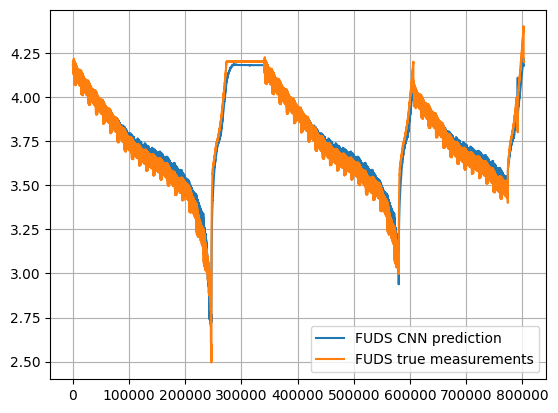

In [8]:
import time
# Test the new trained CNN on the FUDS data on the GPU
# The test consists of the execution time and the RMSE value
min_temperature = min_max_dict["T"][0]
max_temperature = min_max_dict["T"][1]
fuds_scaled_voltage = (U-min_voltage)/(max_voltage-min_voltage)
fuds_scaled_temperature = (T-min_temperature)/(max_temperature-min_temperature)
fuds_cnn_dict = {"soc":fuds_log["SOC"],
                 "I":I,
                 "T":fuds_scaled_temperature,
                 "V":fuds_scaled_voltage}

fuds_cnn_list = []
CNN_1D_data_format(sub_dic=fuds_cnn_dict,
                   formatted_data=fuds_cnn_list,
                   sequence_length=cnn_sequence_length)

fuds_cnn_dataset = CNN_1D_dataset(fuds_cnn_list,input_keys=["soc","I","T"]) 
new_cnn_time = []
cnn_test_loss, cnn_prediction, cnn_true_measurement = None, None, None
for _ in range(5):
    start_time = time.perf_counter()
    cnn_test_loss, cnn_prediction, cnn_true_measurement = test_model(model=cnn_model,
                                                                    batch_size=cnn_batch_size,
                                                                    test_set=fuds_cnn_dataset,
                                                                    device=device,
                                                                    return_prediction=True)
    end_time = time.perf_counter()
    new_cnn_time.append(end_time-start_time)

# Unscale predictions and true measurments
cnn_prediction = np.array(cnn_prediction)*(max_voltage-min_voltage)+min_voltage
cnn_true_measurement = np.array(cnn_true_measurement)*(max_voltage-min_voltage)+min_voltage

# Plot results
plt.plot(cnn_prediction, label="FUDS CNN prediction")
plt.plot(cnn_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

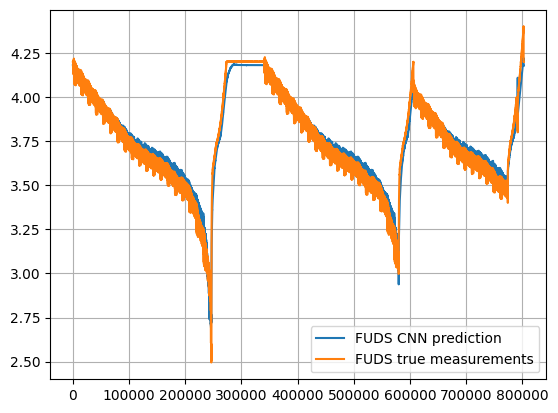

CNN_model(
  (convs): Sequential(
    (0): Conv1d(3, 164, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(164, 164, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(164, 164, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): Conv1d(164, 164, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=328, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [9]:
# Test the new trained CNN on the FUDS data on the CPU
device = "cpu"
cnn_model.to(device)
min_temperature = min_max_dict["T"][0]
max_temperature = min_max_dict["T"][1]
fuds_scaled_voltage = (U-min_voltage)/(max_voltage-min_voltage)
fuds_scaled_temperature = (T-min_temperature)/(max_temperature-min_temperature)
fuds_cnn_dict = {"soc":fuds_log["SOC"],
                 "I":I,
                 "T":fuds_scaled_temperature,
                 "V":fuds_scaled_voltage}

fuds_cnn_list = []
CNN_1D_data_format(sub_dic=fuds_cnn_dict,
                   formatted_data=fuds_cnn_list,
                   sequence_length=cnn_sequence_length)

fuds_cnn_dataset = CNN_1D_dataset(fuds_cnn_list,input_keys=["soc","I","T"]) 
new_cnn_time_cpu = []
cnn_test_loss, cnn_prediction, cnn_true_measurement = None, None, None
for _ in range(5):
    start_time = time.perf_counter()
    cnn_test_loss, cnn_prediction, cnn_true_measurement = test_model(model=cnn_model,
                                                                    batch_size=cnn_batch_size,
                                                                    test_set=fuds_cnn_dataset,
                                                                    device=device,
                                                                    return_prediction=True)
    end_time = time.perf_counter()
    new_cnn_time_cpu.append(end_time-start_time)

# Unscale predictions and true measurments
cnn_prediction = np.array(cnn_prediction)*(max_voltage-min_voltage)+min_voltage
cnn_true_measurement = np.array(cnn_true_measurement)*(max_voltage-min_voltage)+min_voltage

# Force output between eod and eoc
# cnn_prediction = np.clip(cnn_prediction,2.5,4.2)
# cnn_true_measurement = np.clip(cnn_true_measurement,2.5,4.2)

# Plot results
plt.plot(cnn_prediction, label="FUDS CNN prediction")
plt.plot(cnn_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

device = "cuda"
cnn_model.to(device)

new cnn execution time on GPU: 21.637822900000003
 on CPU: 28.343322060000002
ecm 2 execution time: 265.2787886799968


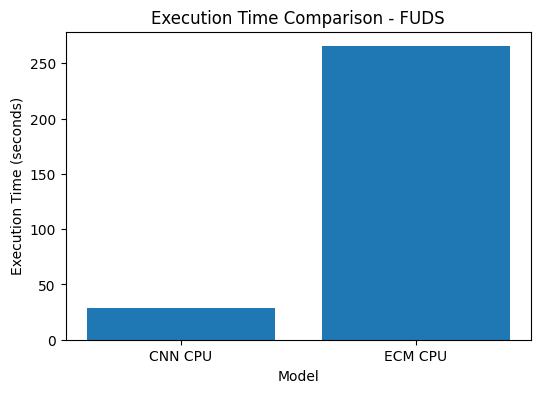

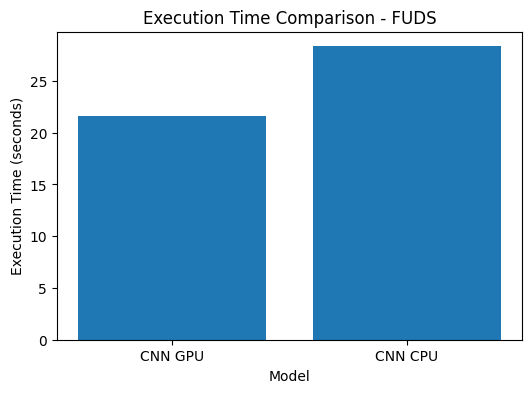

In [10]:
print(f"new cnn execution time on GPU: {np.mean(new_cnn_time)}\n on CPU: {np.mean(new_cnn_time_cpu)}")

# ECM 2nd order average execution time (copied from previous test)
ecm_2_time = 265.2787886799968
print(f"ecm 2 execution time: {np.mean(ecm_2_time)}")

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(['CNN CPU', "ECM CPU"], [np.mean(new_cnn_time_cpu), ecm_2_time])
plt.xlabel('Model')
plt.ylabel('Execution Time (seconds)')
# plt.savefig("ecm_cnn_cpu_new_trained_fuds_execution_time.pdf")
plt.title('Execution Time Comparison - FUDS')
plt.show()

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(['CNN GPU', 'CNN CPU'], [np.mean(new_cnn_time), np.mean(new_cnn_time_cpu)])
plt.xlabel('Model')
plt.ylabel('Execution Time (seconds)')
# plt.savefig("cnn_cpu_gpu_new_trained_fuds_execution_time.pdf")
plt.title('Execution Time Comparison - FUDS')
plt.show()


In [11]:
rmse_ecm = rmse(fuds_log["V"],U)
rmse_cnn = rmse(cnn_prediction, cnn_true_measurement)
print(f"RMSE ECM = {rmse_ecm}\nRMSE CNN = {rmse_cnn}")

RMSE ECM = 0.039258992917425385
RMSE CNN = 0.04680537059903145


In [12]:
# Save the best model
torch.save(cnn_model.state_dict(), 'best_cnn_fine_tuned.pth')